# LoGPT Post Training Analysis

This notebook will focus on analyzing key metrics of the GPT2 model trainied on 124M parameters after the pre-training stage. Will include:
- Analyze Training Loss and LR schedule 
- Gradient Norm and Throughput 
- ROUGE and BERTScore breakdowns 
- Generalization Gap + Val loss vs Perplexity 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from datetime import datetime
%matplotlib inline

In [2]:
# Model and training parameters
sz = "124M"
loss_baseline = {"124M": 3.2924}[sz]

log_dir = "../logs"
data_dir = "../data/training"

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

In [8]:
#Find the latest training log file 
log_files = sorted([f for f in os.listdir(log_dir) if f.startswith("training_log_2000") and f.endswith(".txt")])
if not log_files: 
    raise FileNotFoundError(f"No log files found in {log_dir}")
log_path = os.path.join(log_dir, log_files[-1])
print(f"Using log file: {log_path}")

#Parse the log to extract key data 
train_steps, train_losses = [], []
val_steps, val_losses = [], []
lrs = []

with open(log_path, 'r') as f:
    for line_num, line in enumerate(f, 1):
        line = line.strip()

        #skip empty lines or lines with comments or header line
        if not line or line.startswith("#") or line.startswith("step, "):
            continue

        #skip the metadata lines 
        if not line[0].isdigit():
            continue
        try :    
            #Parse the CSV format 
            parts = [p.strip() for p in line.split(",")]

            if len(parts) < 4: 
                continue 
            step = int(parts[0])
            train_loss_str = parts[1]
            val_loss_str = parts[2]
            lr = float(parts[3])

            #Extract the val or train losses based on availability
            if val_loss_str: 
                val_loss = float(val_loss_str)
                val_steps.append(step)
                val_losses.append(val_loss)
            if train_loss_str: 
                train_loss = float(train_loss_str)
                train_steps.append(step)
                train_losses.append(train_loss)
                lrs.append(lr)
        except Exception as e:
            print(f"Error parsing line {line_num}: {line}")
            print(f"Exception: {e}")
            continue

#Convert to numpy
train_steps = np.array(train_steps)
train_losses = np.array(train_losses)
val_steps = np.array(val_steps)
val_losses = np.array(val_losses)
lrs = np.array(lrs)

print(f"Parsed {len(train_steps)} training steps and {len(val_steps)} validation steps.")
print(f"LR entries: {len(lrs)}")
print(f"\nTraining summary:")
print(f"  Initial train loss: {train_losses[0]:.4f}")
print(f"  Final train loss:   {train_losses[-1]:.4f}")
print(f"  Best val loss:      {val_losses.min():.4f} at step {val_steps[val_losses.argmin()]}")
print(f"  Final val loss:     {val_losses[-1]:.4f}")
print(f"  LR range:           {lrs.min():.2e} → {lrs.max():.2e}")
                

Using log file: ../logs/training_log_2000.txt
Parsed 2000 training steps and 40 validation steps.
LR entries: 2000

Training summary:
  Initial train loss: 127.7310
  Final train loss:   0.8522
  Best val loss:      0.7452 at step 1999
  Final val loss:     0.7452
  LR range:           2.00e-07 → 2.00e-05


In [10]:
#Load test evaulation scores 
resutls_path = os.path.join(log_dir, "test_results.json")
with open(resutls_path, 'r') as f:
    test_data = json.load(f)

results = test_data['results']
test_loss = test_data['avg_loss']
test_perplexity = test_data['perplexity']

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Perplexity: {test_perplexity:.4f}")
print(f"Number of evaluated samples: {len(results)}")

# Extract per-sample scores
rouge1_scores = [r['rouge_scores']['rouge1_f'] for r in results if r.get('rouge_scores')]
rouge2_scores = [r['rouge_scores']['rouge2_f'] for r in results if r.get('rouge_scores')]
rougeL_scores = [r['rouge_scores']['rougeL_f'] for r in results if r.get('rouge_scores')]

bert_p_scores = [r['bert_scores']['precision'][0] for r in results if r.get('bert_scores')]
bert_r_scores = [r['bert_scores']['recall'][0] for r in results if r.get('bert_scores')]
bert_f1_scores = [r['bert_scores']['f1'][0] for r in results if r.get('bert_scores')]

log_types = [r.get('log_type', 'unknown') for r in results]
query_types = [r.get('query_type', 'unknown') for r in results]

print(f"\nROUGE samples: {len(rouge1_scores)}")
print(f"BERTScore samples: {len(bert_f1_scores)}")
print(f"Log types: {set(log_types)}")
print(f"Query types: {set(query_types)}")



Test Loss: 0.7175
Test Perplexity: 2.0493
Number of evaluated samples: 5

ROUGE samples: 5
BERTScore samples: 5
Log types: {'thunderbird', 'health', 'zookeeper', 'openssh', 'linux'}
Query types: {'action_items', 'root_cause', 'summary'}


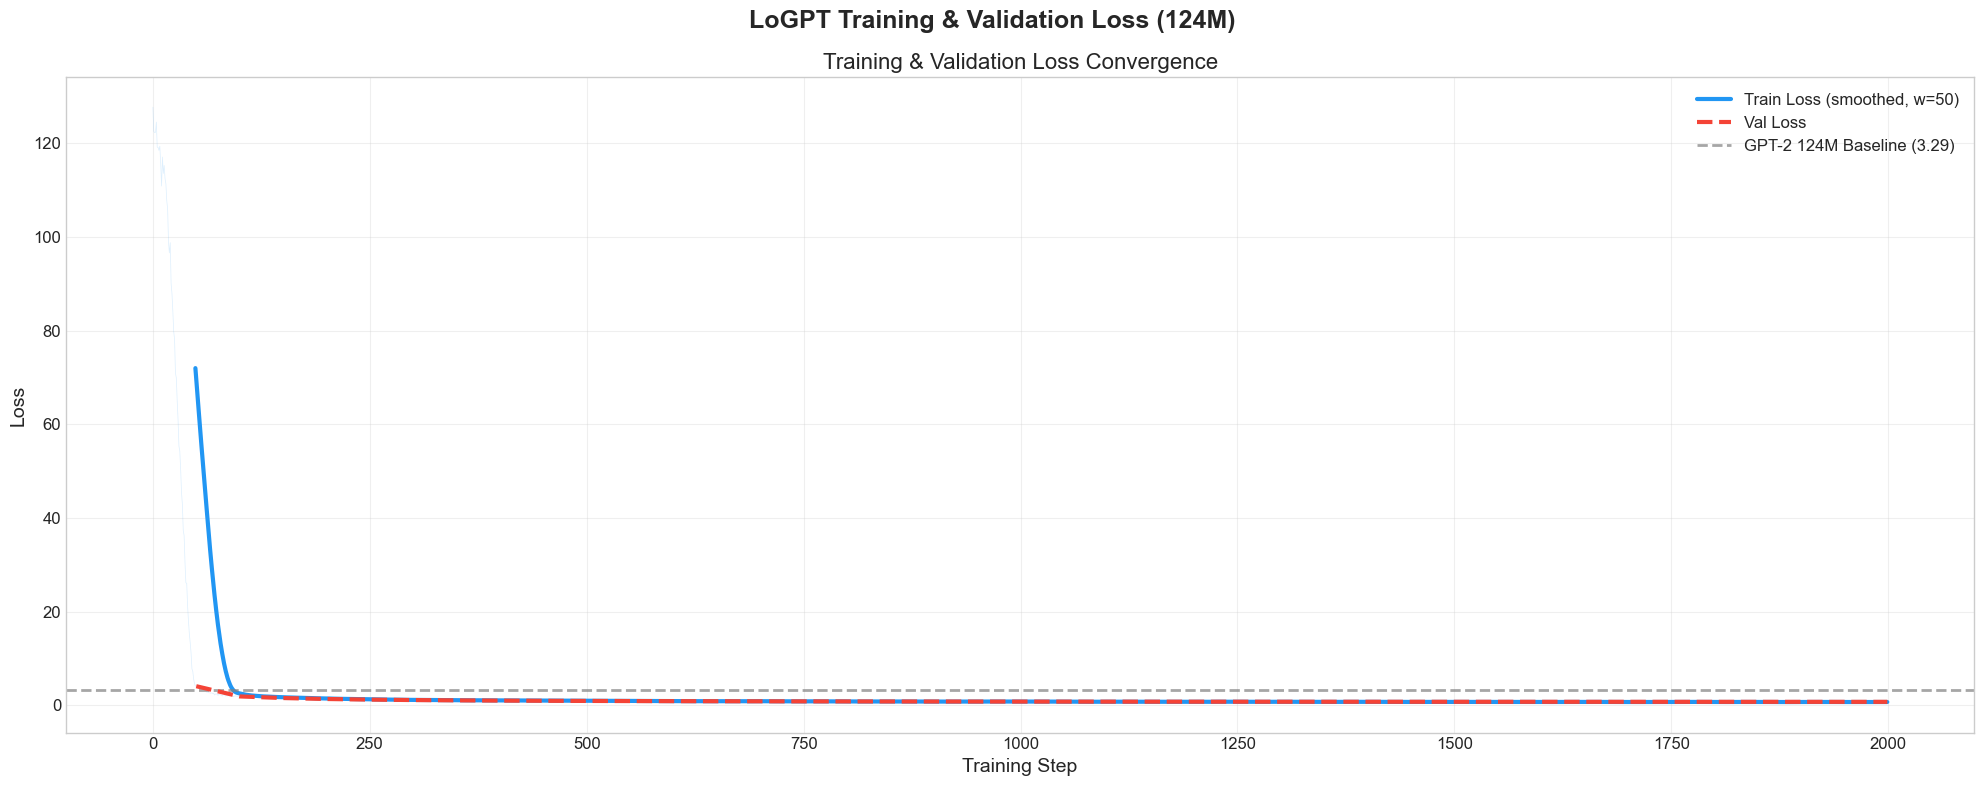

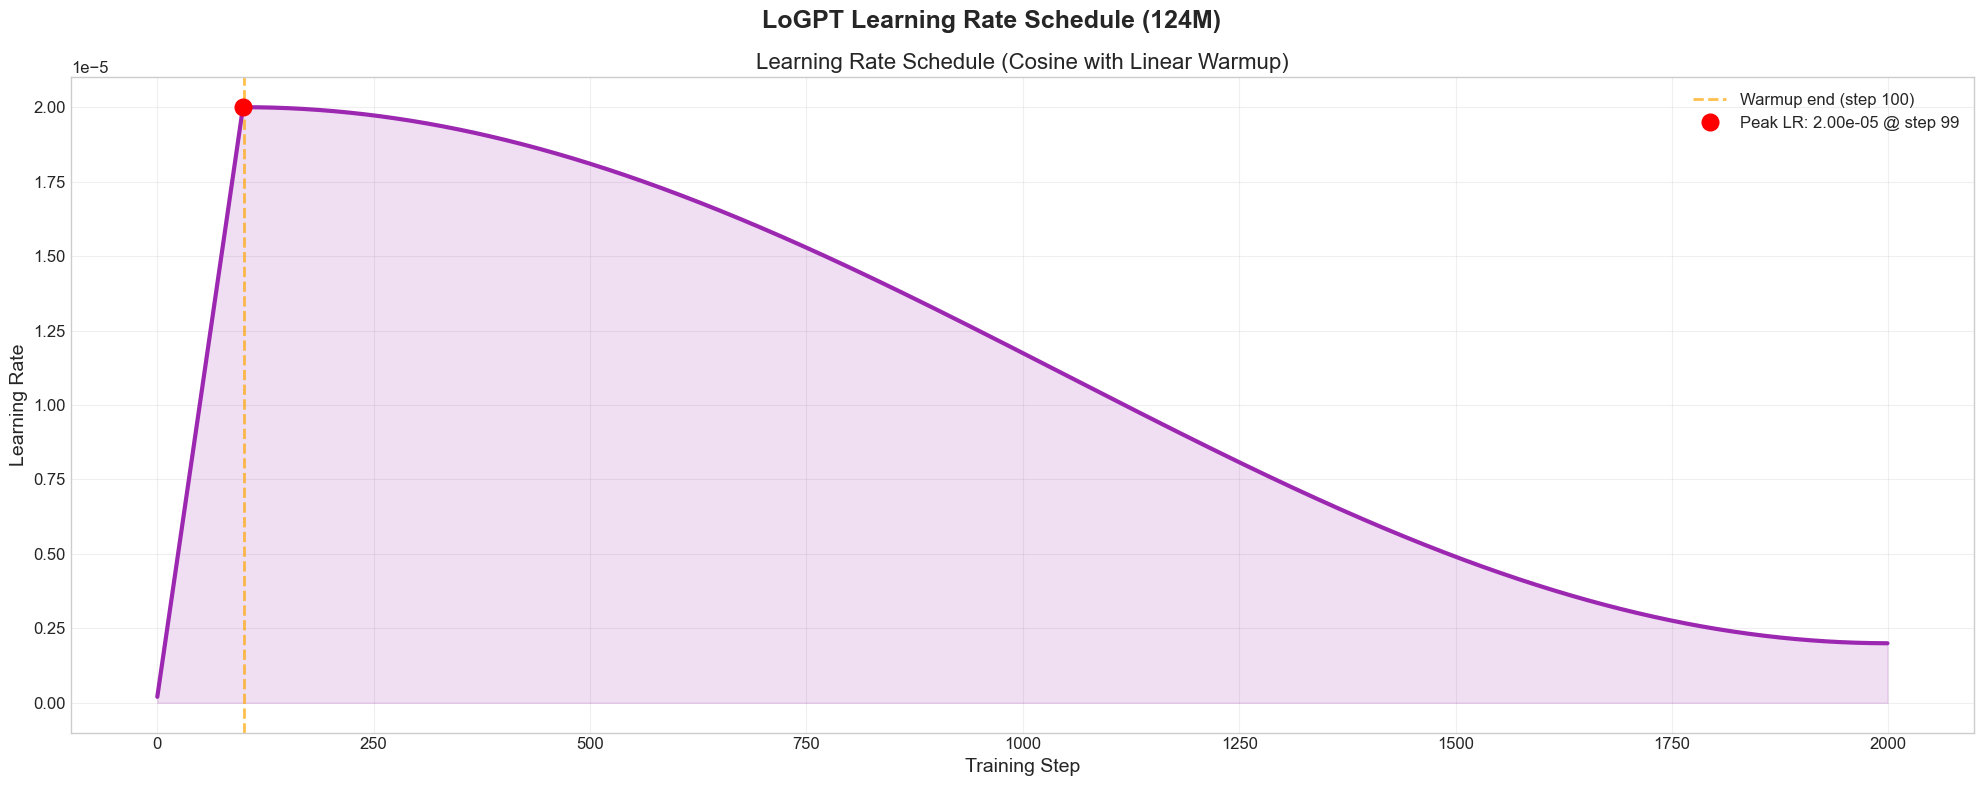

In [ ]:
# Training & Validation Loss
fig, ax = plt.subplots(figsize=(20, 8))
fig.suptitle(f'LoGPT Training & Validation Loss ({sz})', fontsize=18, fontweight='bold')

# Train loss (transparent)
ax.plot(train_steps, train_losses, alpha=0.15, color='#2196F3', linewidth=0.5, label='_nolegend_')

# Smoothed train loss
window = min(50, max(1, len(train_losses) // 10))
if window > 1 and len(train_losses) > window:
    smoothed = np.convolve(train_losses, np.ones(window)/window, mode='valid')
    ax.plot(train_steps[window-1:], smoothed, color='#2196F3', linewidth=3, label=f'Train Loss (smoothed, w={window})')
else:
    ax.plot(train_steps, train_losses, color='#2196F3', linewidth=2.5, label='Train Loss')

# Val loss
ax.plot(val_steps, val_losses, '--', color='#F44336', linewidth=3, markersize=8, label='Val Loss', zorder=5)

# GPT-2 baseline
ax.axhline(y=loss_baseline, color='gray', linestyle='--', alpha=0.7, linewidth=2,
           label=f'GPT-2 {sz} Baseline ({loss_baseline:.2f})')


ax.set_xlabel('Training Step', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.set_title('Training & Validation Loss Convergence', fontsize=16)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(log_dir, 'panel_1_train_val_loss.png'), dpi=150, bbox_inches='tight')
plt.show()

# Panel 2: Learning Rate Schedule

fig, ax = plt.subplots(figsize=(20, 8))
fig.suptitle(f'LoGPT Learning Rate Schedule ({sz})', fontsize=18, fontweight='bold')

if len(lrs) > 0:
    ax.plot(train_steps[:len(lrs)], lrs, color='#9C27B0', linewidth=3)
    ax.fill_between(train_steps[:len(lrs)], 0, lrs, alpha=0.15, color='#9C27B0')
    ax.axvline(x=100, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Warmup end (step 100)')
    
    # Mark peak LR
    peak_idx = lrs.argmax()
    ax.plot(train_steps[peak_idx], lrs[peak_idx], 'o', color='red', markersize=12, 
            label=f'Peak LR: {lrs[peak_idx]:.2e} @ step {train_steps[peak_idx]}', zorder=10)
    
    ax.set_ylabel('Learning Rate', fontsize=14)
    ax.legend(fontsize=12, loc='upper right')
    ax.ticklabel_format(axis='y', style='scientific', scilimits=(-5, -5))
else:
    ax.text(0.5, 0.5, 'No LR data available', ha='center', va='center', 
            transform=ax.transAxes, fontsize=16)

ax.set_xlabel('Training Step', fontsize=14)
ax.set_title('Learning Rate Schedule (Cosine with Linear Warmup)', fontsize=16)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(log_dir, 'panel_2_learning_rate.png'), dpi=150, bbox_inches='tight')
plt.show()

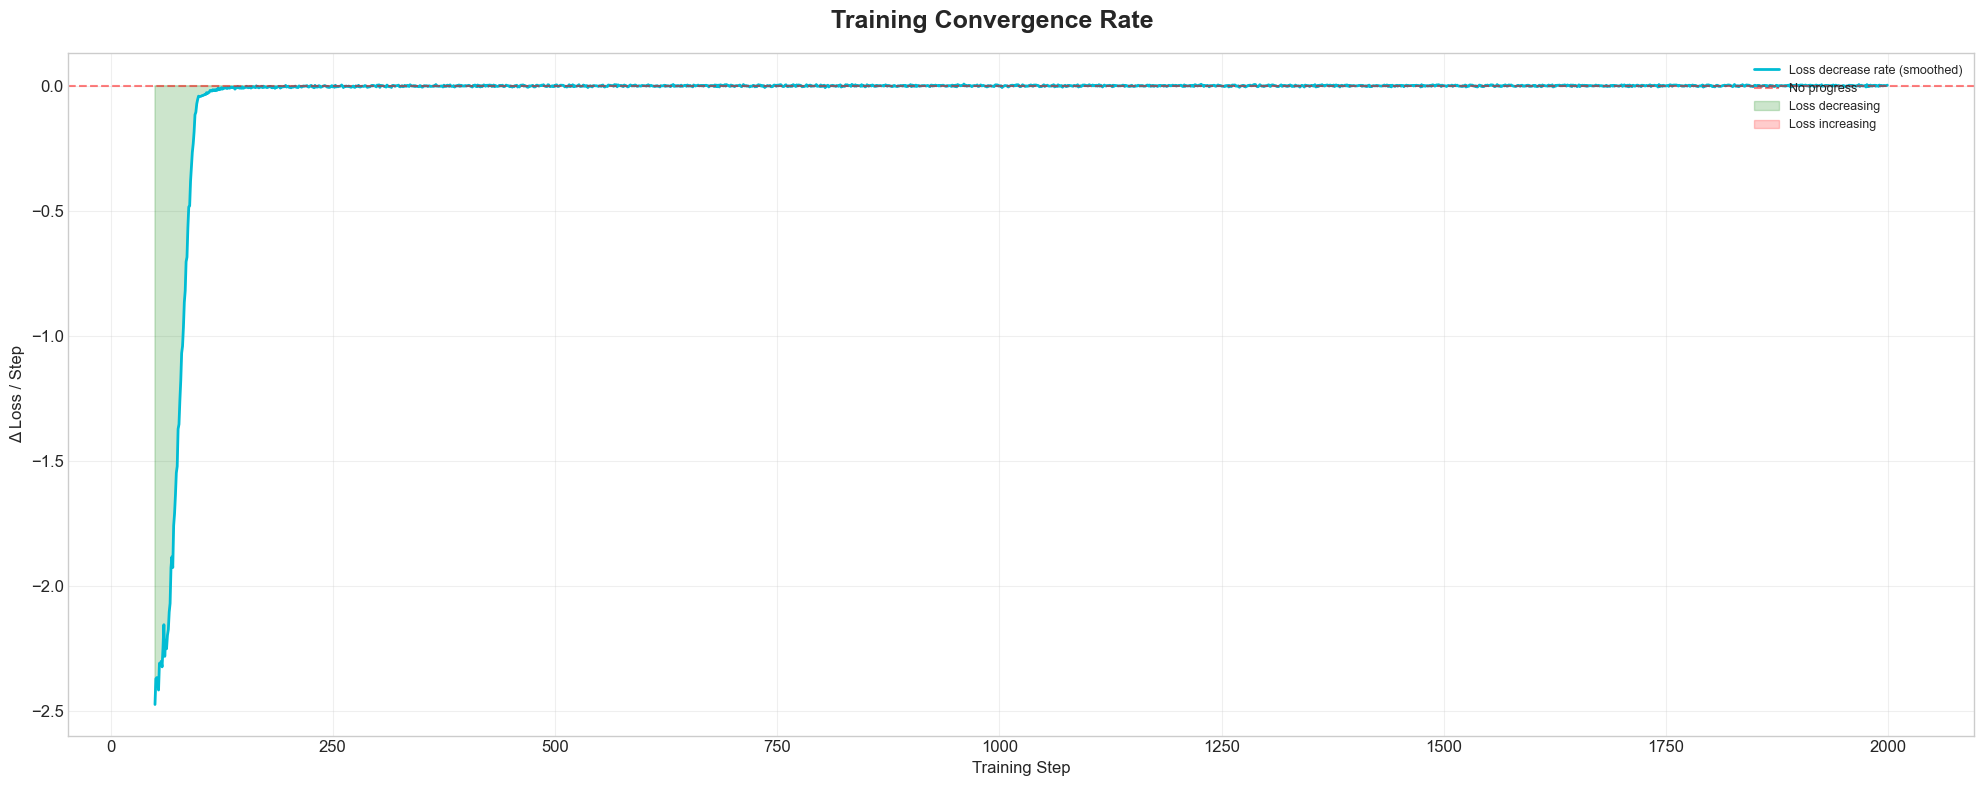

In [17]:
#Loss convergence analysis
fig, ax = plt.subplots(figsize=(20, 8))
fig.suptitle(f'Training Convergence Rate', fontsize=18, fontweight='bold')

#Compute moving average loss decrease rate 
window = 50
if len(train_losses) > window:
    # Rate of loss decrease per step
    loss_diffs = np.diff(train_losses)
    smoothed_rate = np.convolve(loss_diffs, np.ones(window)/window, mode='valid')
    
    ax.plot(train_steps[window:len(smoothed_rate)+window], smoothed_rate, 
            color='#00BCD4', linewidth=2, label='Loss decrease rate (smoothed)')
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='No progress')
    
    # Highlight phases
    ax.fill_between(train_steps[window:len(smoothed_rate)+window], 
                     smoothed_rate, 0, where=(smoothed_rate < 0), 
                     alpha=0.2, color='green', label='Loss decreasing')
    ax.fill_between(train_steps[window:len(smoothed_rate)+window], 
                     smoothed_rate, 0, where=(smoothed_rate > 0), 
                     alpha=0.2, color='red', label='Loss increasing')
    
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Δ Loss / Step')
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(log_dir, 'panel_3_4_lr_convergence.png'), dpi=150, bbox_inches='tight')
plt.show()
    

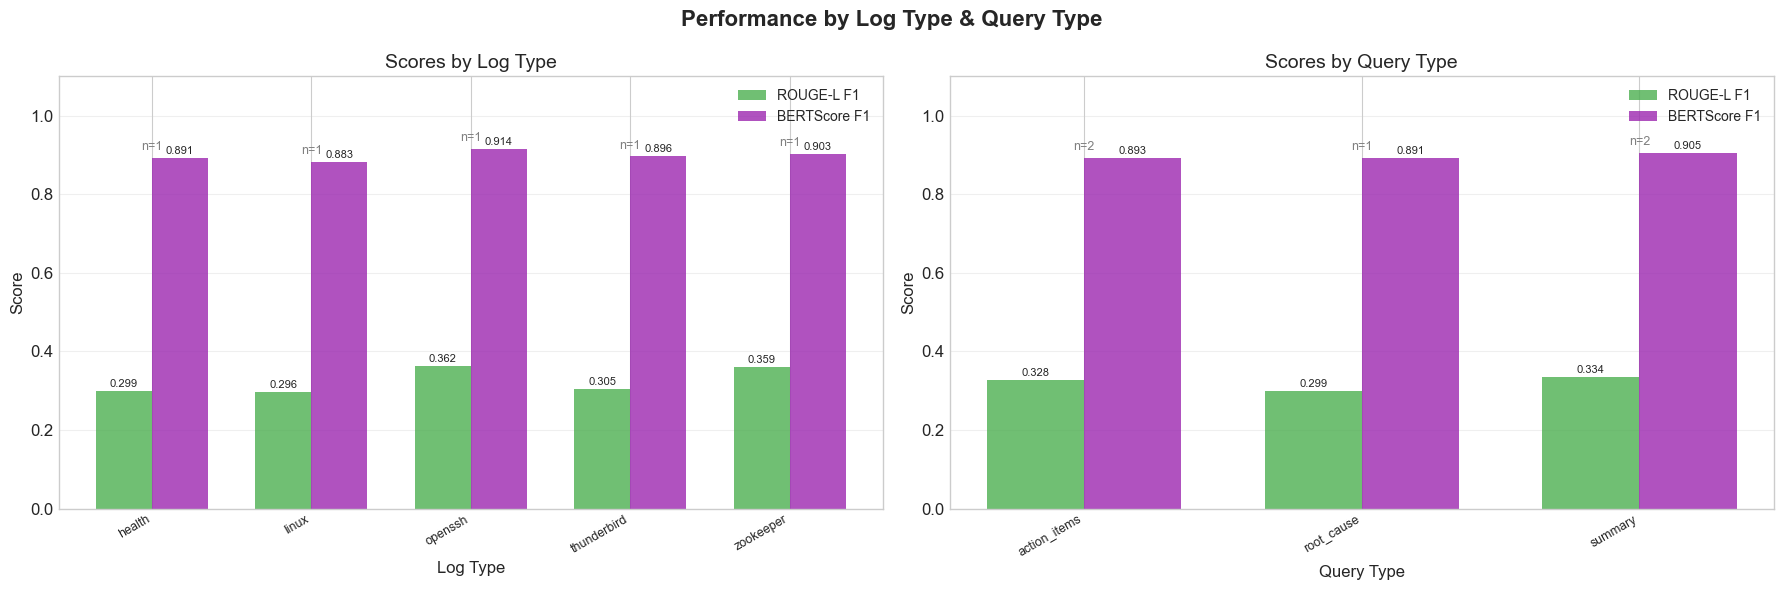

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Performance by Log Type & Query Type', fontsize=16, fontweight='bold')

# Plot ROUGE and BERTScore by Log Type
ax = axes[0]
unique_log_types = sorted(set(log_types))
x = np.arange(len(unique_log_types))
bar_width = 0.35

rougeL_by_type = []
bert_by_type = []
counts_by_type = []

for lt in unique_log_types:
    lt_rouge = [rougeL_scores[i] for i in range(len(results)) if log_types[i] == lt]
    lt_bert = [bert_f1_scores[i] for i in range(len(results)) if log_types[i] == lt]
    rougeL_by_type.append(np.mean(lt_rouge) if lt_rouge else 0)
    bert_by_type.append(np.mean(lt_bert) if lt_bert else 0)
    counts_by_type.append(len(lt_rouge))

bars1 = ax.bar(x - bar_width/2, rougeL_by_type, bar_width, label='ROUGE-L F1', color='#4CAF50', alpha=0.8)
bars2 = ax.bar(x + bar_width/2, bert_by_type, bar_width, label='BERTScore F1', color='#9C27B0', alpha=0.8)

# Add count labels
for i, (b1, b2, count) in enumerate(zip(bars1, bars2, counts_by_type)):
    max_h = max(b1.get_height(), b2.get_height())
    ax.text(i, max_h + 0.02, f'n={count}', ha='center', fontsize=9, color='gray')

# Value labels
for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            ax.text(bar.get_x() + bar.get_width()/2., h + 0.005,
                    f'{h:.3f}', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Log Type')
ax.set_ylabel('Score')
ax.set_title('Scores by Log Type')
ax.set_xticks(x)
ax.set_xticklabels(unique_log_types, rotation=30, ha='right', fontsize=9)
ax.set_ylim(0, 1.1)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Plot ROUGE and BERTScore by Query Type
ax = axes[1]
unique_query_types = sorted(set(query_types))
x = np.arange(len(unique_query_types))

rougeL_by_query = []
bert_by_query = []
counts_by_query = []

for qt in unique_query_types:
    qt_rouge = [rougeL_scores[i] for i in range(len(results)) if query_types[i] == qt]
    qt_bert = [bert_f1_scores[i] for i in range(len(results)) if query_types[i] == qt]
    rougeL_by_query.append(np.mean(qt_rouge) if qt_rouge else 0)
    bert_by_query.append(np.mean(qt_bert) if qt_bert else 0)
    counts_by_query.append(len(qt_rouge))

bars1 = ax.bar(x - bar_width/2, rougeL_by_query, bar_width, label='ROUGE-L F1', color='#4CAF50', alpha=0.8)
bars2 = ax.bar(x + bar_width/2, bert_by_query, bar_width, label='BERTScore F1', color='#9C27B0', alpha=0.8)

for i, (b1, b2, count) in enumerate(zip(bars1, bars2, counts_by_query)):
    max_h = max(b1.get_height(), b2.get_height())
    ax.text(i, max_h + 0.02, f'n={count}', ha='center', fontsize=9, color='gray')

for bars in [bars1, bars2]:
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            ax.text(bar.get_x() + bar.get_width()/2., h + 0.005,
                    f'{h:.3f}', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Query Type')
ax.set_ylabel('Score')
ax.set_title('Scores by Query Type')
ax.set_xticks(x)
ax.set_xticklabels(unique_query_types, rotation=30, ha='right', fontsize=9)
ax.set_ylim(0, 1.1)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(log_dir, 'panel_7_by_type.png'), dpi=150, bbox_inches='tight')
plt.show()